In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
import numpy as np
import missingno

from IPython.display import display

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, fbeta_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from category_encoders import BinaryEncoder

import tensorflow
from tensorflow.keras import optimizers, Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Input, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.regularizers import L1L2
import tensorflow_addons as tfa

import sys
from impyute.imputation.ts import moving_window
sys.setrecursionlimit(100000) #Increase the recursion limit of the OS

In [2]:
df = pd.read_csv("train_data.csv")
timestep = 8 #from 1 to 23 (17 with the current NaN strategy)
threshold_for_classification = -6.5
X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
fill_X = -0.01
seed = 11
features = ['event_id','time_to_tca', 'risk', 'c_time_lastob_end', 'c_time_lastob_start', 
         'max_risk_estimate', 'c_ctdot_r', 'c_obs_used', 'miss_distance',
         'c_obs_available','c_recommended_od_span','c_object_type_PAYLOAD', 
         'c_object_type_UNKNOWN','c_actual_od_span', 
         'c_cr_area_over_mass', 't_h_per', 'relative_velocity_t', 
         'relative_speed', 't_rcs_estimate',  'c_cd_area_over_mass', 
         'c_crdot_t', 'c_sigma_t', 'c_sigma_rdot', 'max_risk_scaling', 
         't_span']

#RNN hiperparameter
epochs = 150
batch = 64
val_split = 0.25
test_split = 0.25
lr = 0.0001
adam = tfa.optimizers.RectifiedAdam(lr=1e-3,
                                  total_steps=10000,
                                  warmup_proportion=0.1,
                                  min_lr=1e-6)
class_weight = {True:  300.,
                False: 1.}
verbose = 1


In [3]:
#Dropping first the empty column and then rows with NaNs
df = df.drop("c_rcs_estimate", axis=1)
#df = df.dropna(how='any')

#Filtering events with len=1 or min_tca > 2 or max_tca < 2
def conditions(event):
    x = event["time_to_tca"].values
    return ((x.min()<2.0) & (x.max()>2.0) & (x.shape[0]>1))
df = df.groupby('event_id').filter(conditions)

#OHE for c_object_type (5 categories) -> 5 new features
df["mission_id"] = df["mission_id"].astype('category')
df["c_object_type"] = df["c_object_type"].astype('category')
df = pd.get_dummies(df)

columns = list(df.columns.values)
imputed_training = moving_window(df.values)
df = pd.DataFrame(imputed_training, columns=columns)

#Getting y as 1D-array
y = df.groupby(["event_id"])["risk"].apply(lambda x: x.iloc[-1]).values.reshape(-1, 1)

#Scaling y
_ = y_scaler.fit(df["risk"].values.reshape(-1, 1)) #using the whole risk feature to scale the target 'y'
y = y_scaler.transform(y)

#Getting X as df (dropping rows with tca < 2) 
df = df.loc[df["time_to_tca"]>2]

#Scaling X
df = pd.DataFrame(X_scaler.fit_transform(df), columns=df.columns)

df = df[features]

#Transforming X into a 3D-array
events = df["event_id"].nunique() #rows
features = len(df.columns) #columns

X = np.zeros((events,timestep,features))
X.fill(fill_X)

i = 0
def df_to_3darray(event):
    global X, i
    #Transforming an event to time series (1,timesteps, columns)
    row = event.values.reshape(1,event.shape[0],event.shape[1])
    #Condition is needed to slice arrays correctly
    #Condition -> is timestep greater than the event's time series length? 
    if(timestep>=row.shape[1]):
        X[i:i+1,-row.shape[1]:,:] = row
    else:
        X[i:i+1,:,:] = row[:,-timestep:,:]
    #index to iterate over X array
    i = i + 1
    #dataframe remains intact, while X array has been filled.
    return event

df.groupby("event_id").apply(df_to_3darray)

#Dropping event_id to remove noise
X = X[:,:,1:]

#TODO: Padding with specific values column-wise instead of zeros.
#TODO: Separating time dependent and independent feature in 2 X arrays

print(X.shape, y.shape)

(8892, 8, 24) (8892, 1)


In [4]:
#computing scaled threshold 
th = np.array([threshold_for_classification]).reshape(-1,1)
th = y_scaler.transform(th)
threshold_scaled = th[0,0]

#Splitting arrays
y_boolean = (y > threshold_scaled).reshape(-1,1)
X_train, X_test, y_train_numeric, y_test_numeric = train_test_split(X, y, 
                                                    stratify=y_boolean, 
                                                    shuffle=True,
                                                    random_state=seed,
                                                    test_size = test_split
                                                  )

y_train_boolean = (y_train_numeric > threshold_scaled).reshape(-1,1)
X_train, X_val, y_train_numeric, y_val_numeric = train_test_split(X_train, y_train_numeric, 
                                                    stratify=y_train_boolean, 
                                                    shuffle=True,
                                                    random_state=seed,
                                                    test_size = val_split
                                                  )
#transforming it into a classification task -> y_train, y_test boolean
y_train = (y_train_numeric > threshold_scaled).reshape(-1,1)
y_val = (y_val_numeric > threshold_scaled).reshape(-1,1)
y_test = (y_test_numeric > threshold_scaled).reshape(-1,1)

#Percentage of high risks in train
print("TRAIN {:0.1f}, {:0.1f}, {:0.3f}".format(np.sum(y_train), y_train.shape[0], np.sum(y_train)/y_train.shape[0]))
#Percentage of high risks in val
print("VAL   {:0.1f}, {:0.1f}, {:0.3f}".format(np.sum(y_val), y_val.shape[0], np.sum(y_val)/y_val.shape[0]))
#Percentage of high risks in test
print("TEST  {:0.1f}, {:0.1f}, {:0.3f}".format(np.sum(y_test), y_test.shape[0], np.sum(y_test)/y_test.shape[0]))

TRAIN 93.0, 5001.0, 0.019
VAL   31.0, 1668.0, 0.019
TEST  41.0, 2223.0, 0.018


In [5]:
# Model activation selu
input_tensor = Input(batch_shape=(batch, timestep, X_train.shape[2]))
rnn_1 = LSTM(256, stateful=False,activation='selu', dropout=0.0, recurrent_dropout=0.2, return_sequences=True, kernel_regularizer=L1L2(l1=0.0, l2=0.001))(input_tensor)
batch_1 = BatchNormalization()(rnn_1)
rnn_2 = LSTM(128, stateful=False,activation='selu', dropout=0.0, recurrent_dropout=0.2, return_sequences=True, kernel_regularizer=L1L2(l1=0.0, l2=0.001))(batch_1)
batch_2 = BatchNormalization()(rnn_2)
rnn_3 = LSTM(64, stateful=False,activation='selu', dropout=0.0, recurrent_dropout=0.1, return_sequences=True, kernel_regularizer=L1L2(l1=0.0, l2=0.001))(batch_2)
batch_3 = BatchNormalization()(rnn_3)
rnn_3 = LSTM(32, stateful=False,activation='selu', dropout=0.0, recurrent_dropout=0.1, return_sequences=True, kernel_regularizer=L1L2(l1=0.0, l2=0.001))(batch_2)
batch_3 = BatchNormalization()(rnn_3)
rnn_3 = LSTM(16, stateful=False,activation='selu', dropout=0.0, recurrent_dropout=0.1, return_sequences=True, kernel_regularizer=L1L2(l1=0.0, l2=0.001))(batch_2)
batch_3 = BatchNormalization()(rnn_3)
rnn_4 = LSTM(4, stateful=False,activation='selu', dropout=0.0, recurrent_dropout=0.1, return_sequences=False, kernel_regularizer=L1L2(l1=0.0, l2=0.001))(batch_2)
batch_4 = BatchNormalization()(rnn_4)
output_tensor = Dense(units = 1, activation='sigmoid')(batch_4)

model = Model(inputs=input_tensor,
              outputs= output_tensor)

model.compile(loss='binary_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(64, 8, 24)]             0         
_________________________________________________________________
lstm (LSTM)                  (64, 8, 256)              287744    
_________________________________________________________________
batch_normalization (BatchNo (64, 8, 256)              1024      
_________________________________________________________________
lstm_1 (LSTM)                (64, 8, 128)              197120    
_________________________________________________________________
batch_normalization_1 (Batch (64, 8, 128)              512       
_________________________________________________________________
lstm_5 (LSTM)                (64, 4)                   2128      
_________________________________________________________________
batch_normalization_5 (Batch (64, 4)                   16    

In [6]:
model_history = model.fit(X_train, y_train, 
                          epochs=epochs, 
                          batch_size=batch, 
                          #shuffle=True, #OJO
                          validation_data=(X_val, y_val),
                          verbose=verbose,
                          class_weight=class_weight
                         ).history

Train on 5001 samples, validate on 1668 samples
Epoch 1/150
5001/5001 [==============================] - 14s 3ms/sample - loss: 5.6949 - accuracy: 0.4189 - val_loss: 3.8673 - val_accuracy: 0.0192
Epoch 2/150
5001/5001 [==============================] - 4s 837us/sample - loss: 4.5980 - accuracy: 0.4263 - val_loss: 3.5002 - val_accuracy: 0.0641
Epoch 3/150
5001/5001 [==============================] - 4s 755us/sample - loss: 3.1839 - accuracy: 0.4055 - val_loss: 3.2727 - val_accuracy: 0.2794
Epoch 4/150
5001/5001 [==============================] - 4s 779us/sample - loss: 3.0253 - accuracy: 0.3859 - val_loss: 2.9034 - val_accuracy: 0.2986
Epoch 5/150
5001/5001 [==============================] - 4s 785us/sample - loss: 2.5196 - accuracy: 0.4109 - val_loss: 2.6975 - val_accuracy: 0.4083
Epoch 6/150
5001/5001 [==============================] - 4s 763us/sample - loss: 2.3802 - accuracy: 0.4507 - val_loss: 3.1562 - val_accuracy: 0.5809
Epoch 7/150
5001/5001 [==============================] - 4s

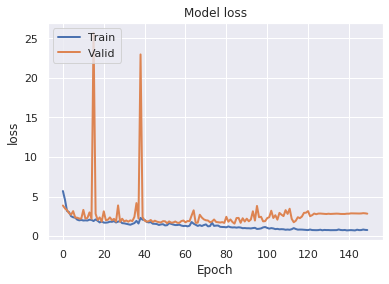

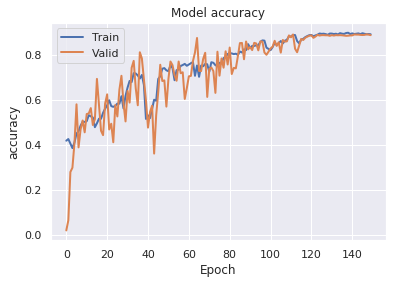

In [7]:
sns.set()

for graph in ['loss', 'accuracy']:
    
    plt.plot(model_history[graph], linewidth=2, label='Train')
    plt.plot(model_history['val_'+graph], linewidth=2, label='Valid')
    
    plt.legend(loc='upper left')
    plt.title('Model '+graph)
    plt.ylabel(graph)
    plt.xlabel('Epoch')
    
    plt.show()

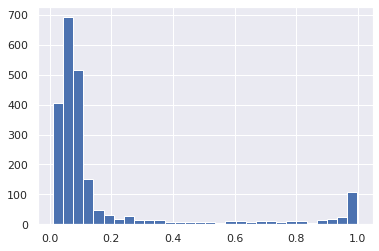

Best score: 1.2018128064599158
Best threshold: 0.6926888388388388


/home/jaime/.local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no predicted samples.

/home/jaime/.local/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning:

divide by zero encountered in double_scalars

/home/jaime/.local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no predicted samples.

/home/jaime/.local/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning:

divide by zero encountered in double_scalars



In [8]:
high_risk_real_value = -5.0
low_risk_real_value  = -6.0001

def threshold(y_model):
    
    best_threshold = 0
    best_score = 100
    thresholds = np.linspace(0.00001,0.99999,1000)
    
    for th in thresholds:
        
        y_pred = (y_model > th).reshape(-1,1)
        
        #rescaling data
        y_test_scaled = y_scaler.inverse_transform(y_test_numeric)

        #getting numeric predictions from boolean predictions
        y_pred_numeric = np.zeros((y_pred.shape[0],y_pred.shape[1]))
        y_pred_numeric[y_pred==True] = high_risk_real_value
        y_pred_numeric[y_pred==False] = low_risk_real_value

        #getting predictions greater than -6.0 in real data (y_test_scaled)
        y_pred_mse = y_pred_numeric[np.where(y_test_scaled >= -6.0)]
        y_test_mse = y_test_scaled[np.where(y_test_scaled >= -6.0)]

        mse = mean_squared_error(y_test_mse, y_pred_mse)

        y_real_bool = (y_test_scaled >= -6.0).reshape(-1,1)

        f_beta = fbeta_score(y_real_bool, y_pred, 2)
        score = mse / f_beta
        
        if (score<best_score):
            best_score = score
            best_threshold = th
        
    print('Best score:', best_score)
    print('Best threshold:', best_threshold)
        
    return best_threshold

#Predicting with model
y_model = model.predict(X_test, batch_size=batch)
plt.hist(y_model, bins=30)
plt.show()
best_threshold = threshold(y_model)

LSTM model: 1.202, 0.364, 0.303


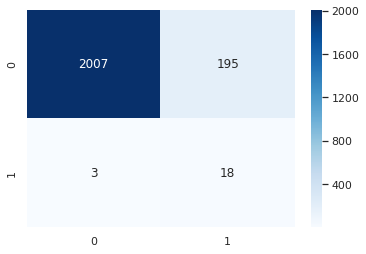

Constant prediction: 10.363, 0.472, 0.046


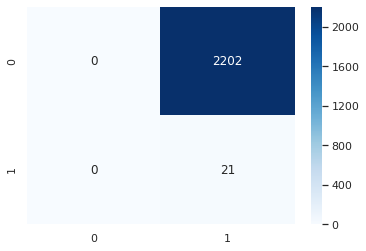

Predicting last value: 1.172, 0.502, 0.429


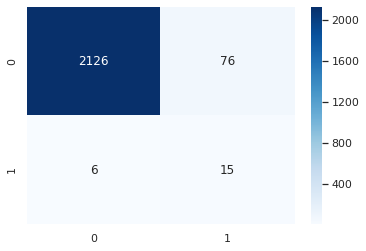

In [9]:
#Model Evaluation
classification_threshold = best_threshold

def evaluate(name, y_pred):
    
    #rescaling data
    y_test_scaled = y_scaler.inverse_transform(y_test_numeric)
    
    #getting numeric predictions from boolean predictions
    y_pred_numeric = np.zeros((y_pred.shape[0],y_pred.shape[1]))
    y_pred_numeric[y_pred==True] = high_risk_real_value
    y_pred_numeric[y_pred==False] = low_risk_real_value
    
    #getting predictions greater than -6.0 in real data (y_test_scaled)
    y_pred_mse = y_pred_numeric[np.where(y_test_scaled >= -6.0)]
    y_test_mse = y_test_scaled[np.where(y_test_scaled >= -6.0)]
    
    mse = mean_squared_error(y_test_mse, y_pred_mse)
    
    y_real_bool = (y_test_scaled >= -6.0).reshape(-1,1)
    
    f_beta = fbeta_score(y_real_bool, y_pred, 2)
    score = mse / f_beta
    print(name, "{:0.3f}, {:0.3f}, {:0.3f}".format(score, mse, f_beta))
        
    hm = sns.heatmap(confusion_matrix(y_real_bool, y_pred), annot=True, cmap="Blues", fmt='d')# font size
    bottom, top = hm.get_ylim()
    hm.set_ylim(bottom + 0.5, top - 0.5)
    plt.show()

#LSTM model
y_model = (y_model > classification_threshold).reshape(-1,1)
evaluate("LSTM model:", y_model)

#Predicting -5 always
y_constant = np.ones((y_test.shape[0],y_test.shape[1]), dtype=bool)
evaluate("Constant prediction:", y_constant)

#Predicting last value
y_last = X_test[:,-1,1]
tmp = np.array([-6]).reshape(-1,1)
tmp = y_scaler.transform(tmp)
tmp = tmp[0,0]
y_last = (y_last > tmp).reshape(-1,1)
evaluate("Predicting last value:", y_last)

Predicting last value: 70.873, 30.374, 0.429


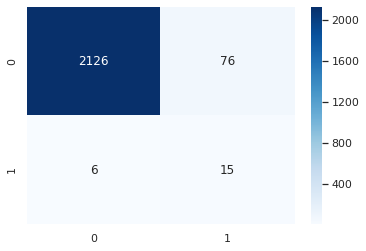

In [10]:
#Predicting last value
def recurrent_evaluate(name, y_pred):
    
    #Scaling both real predicted
    y_pred_scaled = y_scaler.inverse_transform(y_pred)
    y_real_scaled = y_scaler.inverse_transform(y_test_numeric)
    
    #boolean data
    y_pred_bool = (y_pred_scaled >= -6.0).reshape(-1,1)
    y_real_bool = (y_real_scaled >= -6.0).reshape(-1,1)
    f_beta = fbeta_score(y_real_bool, y_pred_bool, 2)
    
    #getting predictions greater than -6.0 in real data (y_real_scaled)
    y_pred_mse = y_pred_scaled[np.where(y_real_scaled >= -6.0)]
    y_real_mse = y_real_scaled[np.where(y_real_scaled >= -6.0)]
    mse = mean_squared_error(y_real_mse, y_pred_mse)
    
    #F-beta score
    score = mse / f_beta
    print(name, "{:0.3f}, {:0.3f}, {:0.3f}".format(score, mse, f_beta))
        
    #Confusion matrix
    hm = sns.heatmap(confusion_matrix(y_real_bool, y_pred_bool), annot=True, cmap="Blues", fmt='d')# font size
    bottom, top = hm.get_ylim()
    hm.set_ylim(bottom + 0.5, top - 0.5)
    plt.show()

    
y_last = X_test[:,-1,1].reshape(-1,1)
y_bool_2 = recurrent_evaluate("Predicting last value:", y_last)